In [254]:
import pickle
import numpy as np
from sklearn.preprocessing import RobustScaler,MinMaxScaler
X_ppg,X_qual,X_acc,y_rr,y_respiration,y_inspiration,y_expiration,groups,X_respiration,y_activity,y_label = pickle.load(open('../../affect-recognition/data/tabular_data_8.p','rb'))

In [255]:
from sklearn.preprocessing import OneHotEncoder
index = np.where((y_activity!=0)&(y_activity!=3)&(y_activity!=6)&(y_activity!=8))[0]
index = np.where((y_activity==1))[0]
X_acc = X_acc[index]
y_activity = y_activity[index]
groups = groups[index]
y_activity = OneHotEncoder().fit_transform(y_activity.reshape(-1,1)).todense()
X_fft = np.fft.fft(X_acc[:,:,:],axis=1)
X_fft_real = X_fft.real
X_fft_imag = X_fft.imag
X_fft = np.concatenate([X_fft_real,X_fft_imag],axis=2)
max_value = X_fft.max()
X_fft = X_fft/max_value
# X_fft = X_fft.reshape(-1,256*6)

/home/azim/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [256]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder, MNIST
from torchvision import transforms,datasets
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
from torchsummary import summary
# from tensorboardX import SummaryWriter
X_fft.shape
y_activity = np.array(np.argmax(y_activity,axis=1)).reshape(-1,1)
X_fft.shape,y_activity.shape

((4571, 256, 6), (4571, 1))

In [257]:
import torch.utils.data as data_utils
batch_size = 128
train = data_utils.TensorDataset(torch.from_numpy(X_fft), torch.from_numpy(y_activity))
data_loader = data_utils.DataLoader(train, batch_size=batch_size, shuffle=True)

In [258]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed_length = 100
        self.vocab_size = 5
        self.label_emb = nn.Linear(1,self.embed_length)
        self.n_timesteps = 256
        self.n_channels = 6
        self.input_length = self.n_timesteps * self.n_channels 
        self.model = nn.Sequential(
            nn.Linear(self.input_length, self.input_length//4),
            nn.ReLU(),
#             nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(self.input_length//4, 100)
        )
        self.model2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.embed_length*2, self.embed_length),
            nn.ReLU(True),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),
            nn.Linear(self.embed_length, self.embed_length//2),
            nn.ReLU(),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),
            nn.Linear(self.embed_length//2, 10),
            nn.ReLU(),
#             nn.Dropout(0.3),
            nn.Linear(10,1),
            nn.Sigmoid()
        )
        
    
    def forward(self, x, labels):
        x = x.view(x.size(0), self.input_length)
        c = self.label_emb(labels.view(labels.size(0),1).float()).view(x.size(0),self.embed_length)
        out = self.model(x.float())
        y = torch.cat([out, c],1)
#         print(y.shape)
        y = self.model2(y)        
        return y.squeeze()
    
    
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_length = 100
        self.embed_length = 100
        self.label_emb = nn.Sequential(nn.Linear(1, self.embed_length))
        self.n_timesteps = 256
        self.n_channels = 6
        self.model = nn.Sequential(
            nn.Linear(self.embed_length*2, self.n_timesteps),
            nn.Tanh(),
            nn.Linear(self.n_timesteps, self.n_timesteps*3),
            nn.Tanh(),
#             nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(self.n_timesteps*3, self.n_timesteps*4),
            nn.Tanh(),
#             nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(self.n_timesteps*4, self.n_timesteps*self.n_channels),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
#         print(z.shape,labels.shape)
        z = z.view(z.size(0), self.input_length)
#         print(labels.shape)
        c = self.label_emb(labels.view(z.size(0),1).float()).view(z.size(0), self.input_length)
#         print(z.shape,c.shape)
        x = torch.cat([z, c],1)
#         print(x.shape)
        out = self.model(x)
        return out.view(x.size(0), self.n_timesteps, self.n_channels)

In [259]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [260]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [261]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 1, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [262]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()
    # train with real images
    real_validity = discriminator(real_images, labels)
#     print(real_validity.detach().shape,Variable(torch.zeros(batch_size)).cuda().detach().shape)
    real_loss = criterion(real_validity, Variable(torch.zeros(batch_size)).cuda())
    real_loss.backward()
    d_optimizer.step()
    
    # train with fake image
    d_optimizer.zero_grad()
    
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 1, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.ones(batch_size)).cuda())
#     print(real_loss,fake_loss)
#     d_loss = real_loss + fake_loss
    fake_loss.backward()
    d_optimizer.step()
    return (real_loss+fake_loss).item()

Starting epoch 0... (5, 1, 256, 6)


/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


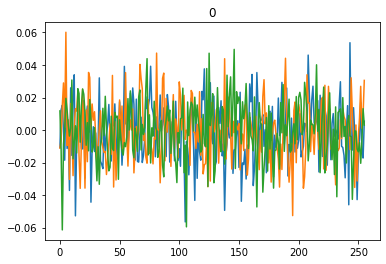

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


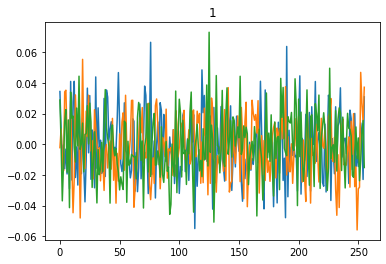

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


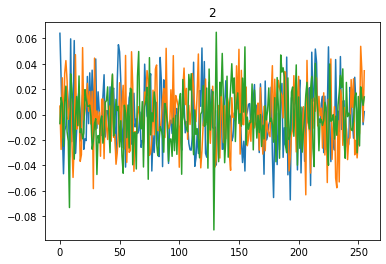

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


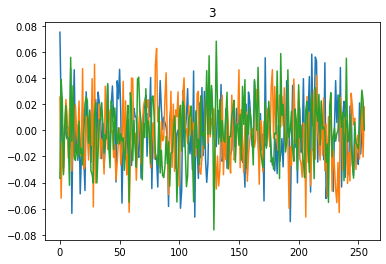

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


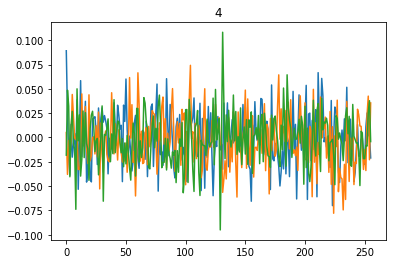

Starting epoch 1... Starting epoch 2... 

In [ ]:
num_epochs = 500
n_critic = 5
display_step = 50
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch), end=' ')
    for i, (images, labels) in enumerate(data_loader):
        
        step = epoch * len(data_loader) + i + 1
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
        if epoch%10==0 and i%100==0:
            z = Variable(torch.randn(5, 100)).cuda()
            labels = torch.LongTensor([i1 for i1 in range(5) for _ in range(1)]).cuda()

            generator.eval()
            x_pred = generator(z, labels).unsqueeze(1).cpu().detach().numpy()*max_value
            labels = labels.cpu().detach().numpy()

            print(x_pred.shape)
            x_pred = x_pred.reshape(-1,256,6)

            import matplotlib.pyplot as plt
            %matplotlib inline
            for k in range(5):
                plt.figure()
                plt.plot(np.fft.ifft(x_pred[k][:,0]+1j*x_pred[k][:,3]))
                plt.plot(np.fft.ifft(x_pred[k][:,1]+1j*x_pred[k][:,4]))
                plt.plot(np.fft.ifft(x_pred[k][:,2]+1j*x_pred[k][:,5]))
                plt.title(labels[k])
                plt.show()
            #         print(d_loss,g_loss)

In [ ]:
z = Variable(torch.randn(50, 100)).cuda()
labels = torch.LongTensor([i for i in range(5) for _ in range(10)]).cuda()

generator.eval()
x_pred = generator(z, labels).unsqueeze(1).cpu().detach().numpy()*max_value
labels = labels.cpu().detach().numpy()

print(x_pred.shape)
x_pred = x_pred.reshape(-1,256,6)

import matplotlib.pyplot as plt
%matplotlib inline
for k in range(50):
    plt.figure()
    plt.plot(np.fft.ifft(x_pred[k][:,0]+1j*x_pred[k][:,3]))
    plt.plot(np.fft.ifft(x_pred[k][:,1]+1j*x_pred[k][:,4]))
    plt.plot(np.fft.ifft(x_pred[k][:,2]+1j*x_pred[k][:,5]))
    plt.title(labels[k])
    plt.show()

In [ ]:
generator.label_emb.weight.cpu().detach().numpy()

In [ ]:
()